In [1]:
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.models.keyedvectors import KeyedVectors
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity
import joblib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import sqlalchemy as sal
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder
from string import punctuation
from tqdm import tqdm

In [2]:
engine = sal.create_engine('mssql+pyodbc://LAPTOP-NNDGMEMB/beth?driver=ODBC+Driver+13+for+SQL+Server?Trusted_Connection=yes')
conn = engine.connect()
data = pd.read_sql_table('violations_content', conn)

In [3]:
# Remove the rows in which the document content is null.
# It happens when documents (documentoId) iniatilly loaded into 'violations_content'
# can't have their content retrieved (e.g. PDF that can't be parsed by PDFMiner)

data = data[~data['docContSplitted'].isna()]

In [6]:
# possible 'serieId' for documents that represent the initial document in a violation process

#serieId  serieNome                     
#344      REPRESENTAÇÃO - Eletrônica        887
#42       DEFESA                            405
#381      RECLAMAÇÃO - Atendimento SUSEP    151
#173      REPRESENTAÇÃO                      49
#341      AUTO - Infração Eletrônico         18
#61       RECLAMAÇÃO                         12
#45       DENÚNCIA                            1

initial_docs = [173,  344, 341, 381,  61,  45]

In [7]:
# filter the dataframe to keep only one document per violation and remove 'DEFESA'

data_orig = data.loc[data['serieId'].isin(initial_docs),:]
data_orig = data_orig.sort_values(by='documentoId', ascending=False)
data_orig = data_orig.drop_duplicates(subset='infracaoId', keep='first')

In [8]:
columns_to_keep = ['infracaoId', 'processoId', 'docContSplitted']

In [9]:
data_orig = data_orig[columns_to_keep]

In [10]:
data_orig.reset_index(drop=True, inplace=True)

In [31]:
data_orig.loc[877]['docContSplitted']

' 20/12/2013, término do prazo para o preenchimento do fip de novembro de 2013 falta: encaminhar as informações do fip/susep com incorreções qualificação do agente supostamente responsável e, sendo o caso, do responsável solidário: aplub - associação dos profissionais liberais universitários do brasil cnpj: 92.672.070/0001-04 código fip: 1006-5 avenida julio de castilho, 10 – centro porto alegre – rs cep:90.030-130 descrição circunstanciada do fato ou do ato constitutivo da suposta infração: a presente representação se deve em face das irregularidades detectadas por meio formulário de atendimento ao público nº 525245 e comunicada através do processo susep nº 15414.200261/2013-66. a sociedade comunicou a designação de ouvidor à susep no dia 30/08/2013. no entanto, tal informação não foi prestada no fip de novembro de 2013. de acordo com a carta-circular susep/dirat/cgrat/nº 008/2013, a informação deveria constar no fip a partir da designação: nos casos de substituição e/ou designação de

In [36]:
def getSentences(text):
    """
    Split the text into sentences by dots provided:
    It is not a dot among the list of common abbreviations such as art., arts., s.a., n.º, doc., docs., fl., fls.,
    dr., drs., cia., cias.
    """

    regex = r'(?<!art)(?<!arts)(?<!\.)(?<!\()(?<!\s[asn])(?<!s.a)(?<!doc)(?<!docs)(?<!fls)(?<!fl)(?<!dr)(?<!drs)(?<!cia)(?<!cias)([\.]{1}\B)'
    return [word for word in re.split(regex, text) if len(word) > 1]

In [37]:
getSentences(data_orig.loc[877]['docContSplitted'])

[' 20/12/2013, término do prazo para o preenchimento do fip de novembro de 2013 falta: encaminhar as informações do fip/susep com incorreções qualificação do agente supostamente responsável e, sendo o caso, do responsável solidário: aplub - associação dos profissionais liberais universitários do brasil cnpj: 92.672.070/0001-04 código fip: 1006-5 avenida julio de castilho, 10 – centro porto alegre – rs cep:90.030-130 descrição circunstanciada do fato ou do ato constitutivo da suposta infração: a presente representação se deve em face das irregularidades detectadas por meio formulário de atendimento ao público nº 525245 e comunicada através do processo susep nº 15414.200261/2013-66',
 ' a sociedade comunicou a designação de ouvidor à susep no dia 30/08/2013',
 ' no entanto, tal informação não foi prestada no fip de novembro de 2013',
 ' de acordo com a carta-circular susep/dirat/cgrat/nº 008/2013, a informação deveria constar no fip a partir da designação: nos casos de substituição e/ou 

### Regex Cleaning

In [39]:
# list of regex to remove expressions which don't carry information
# 0: 'coordenação (geral) de'
# 1: 'ministério da fazenda|economia'
# 2: 'superintendência de seguros privados'
# 3: brazilian postal code
# 4: URL
# 5: brazilian phone numbers
# 6: brazilian addresses
# 7: e-mail (emailregex.com)


regex_list = [r'(coordena[cç][aã]o)\s?-?(geral)?\s?de', r'(minist[eé]rio)\s(da)\s(fazenda|economia)',
 r'(superintend[eê]ncia)\sde\sseguros\sprivados', r'(cep)\:?\s*\b\d{2}\.?\d{3}-?\d{3}\b',
r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',
r'\b(\+55\s?)?\(?([0-9]{2,3}|0((x|[0-9]){2,3}[0-9]{2}))\)?\s*[0-9]{4,5}[- ]*[0-9]{4}\b',
r'\b(rua|r\.|avenida|av\.?|travessa|trav\.?|largo|quadra|qd|alameda|conjunto|conj\.?|estrada|pra[cç]a|rodovia|rod\.?)\s([a-zA-Z_\s]+)[, ]+(\d+)\s?([-/\da-zDA-Z\\ ]+)?\b',
r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])",
]

In [40]:
def regex_substitute(document, regex_list):
    for regex in regex_list:
        document = re.sub(regex, '', document)
    return document

In [41]:
data_orig['regexCleanedText'] = data_orig['docContSplitted'].apply(regex_substitute, args=(regex_list,))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### PoS Tagger

In [47]:
# Load trained POS tagger

brill_tagger = joblib.load('./trained_pos_taggers/POS_tagger_brill.pkl')

### Apply PoS Tagger

In [48]:
tags_to_use = ['ADJ',
 'ADJ|+',
 'ADJ|EST',
 'ADV',
 'ADV-KS',
 'ADV-KS-REL',
 'ADV|+',
 'ADV|EST',
 'ADV|[',
 'ADV|]',
 'IN',
 'IN|EST',
 'N',
 'NPRO',
 'NPROP',
 'NPROP|+',
 'NUM',
 'N|DAD',
 'N|EST',
 'PCP',
 'PDEN',
 'PDEN|EST',
 'PREP',
 'PREP|',
 'PREP|+',
 'PREP|+]',
 'PREP|EST',
 'PREP|[',
 'PREP|]',
 'V',
 'VAUX',
 'VAUX|!',
 'VAUX|+',
 'V|!',
 'V|+',
 'V|EST'
]

In [49]:
def tagging(text):
    tagged = brill_tagger.tag(nltk.word_tokenize(text))
    return ' '.join([word for word, tag in tagged if tag in tags_to_use])

In [50]:
data_orig['posTaggedText'] = data_orig['regexCleanedText'].apply(tagging)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
stemmer = nltk.stem.RSLPStemmer()
stoplist = set(stopwords.words('portuguese') + list(punctuation))

In [58]:
def tokenizer_stemmer(text):
    token_list = nltk.word_tokenize(text, language='portuguese')
    token_list = [token for token in token_list if re.search(r"(?u)\b[0-9a-zÀ-ÿ-]{3,}\b", token)]
    token_list = [token for token in token_list if token not in stoplist]
    token_list = [stemmer.stem(token) for token in token_list]
    listToStr = ' '.join([str(elem) for elem in token_list])
    
    return listToStr

In [166]:
def tokenizer(text):
    token_list = nltk.word_tokenize(text, language='portuguese')
    token_list = [token for token in token_list if re.search(r"(?u)\b[0-9a-zÀ-ÿ-]{3,}\b", token)]
    token_list = [token for token in token_list if token not in stoplist]
    listToStr = ' '.join([str(elem) for elem in token_list])
    
    return listToStr

In [167]:
data_orig['tokenizedText'] = data_orig['posTaggedText'].apply(tokenizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
data_orig['tokenStemText'] = data_orig['posTaggedText'].apply(tokenizer_stemmer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Testing different embeddings

In [84]:
def topNSimilarViolations(sim_matrix, n, violationId):
    
    """
    Returns the 'n' most similar violations for a 'violationId'
    
    'sim_matrix' is a similarity dataframe
    
    """
    
    sim_series = sim_matrix[(sim_matrix.index != violationId)][violationId]
    sim_series = sim_series[sim_series < 0.999].nlargest(n)
    
    return sim_series

#### TF-IDF vectorization

Find the optimal ngram_range in vectorization for Cosine Similarity (cossim)

In this case, "optimal" means the ngram_range that provides the best total cossim (sum of all similarities)

In [65]:
ngram_list = [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7)]

_sum_cossim_list = []
_sum_eucdist_list = []
_sum_cosdis_list = []

for ngram_range in ngram_list:
    
    _vect = TfidfVectorizer(lowercase=False,
                           max_df=0.8,
                           ngram_range=ngram_range)
    
    _doc_vectors = _vect.fit_transform(data_orig['tokenStemText'])
    
    _cosine_similarities = cosine_similarity(_doc_vectors)
    
    _sum_cossim = np.sum(np.triu(_cosine_similarities, k=1))
    
    _euclidean_distances = euclidean_distances(_doc_vectors)
    
    _sum_eucdist = np.sum(np.triu(_euclidean_distances, k=1))
    
    _cosine_distances = cosine_distances(_doc_vectors)
    
    _sum_cosdis = np.sum(np.triu(_cosine_distances, k=1))
    
    _sum_cossim_list.append(_sum_cossim)
    _sum_eucdist_list.append(_sum_eucdist)
    _sum_cosdis_list.append(_sum_cosdis)

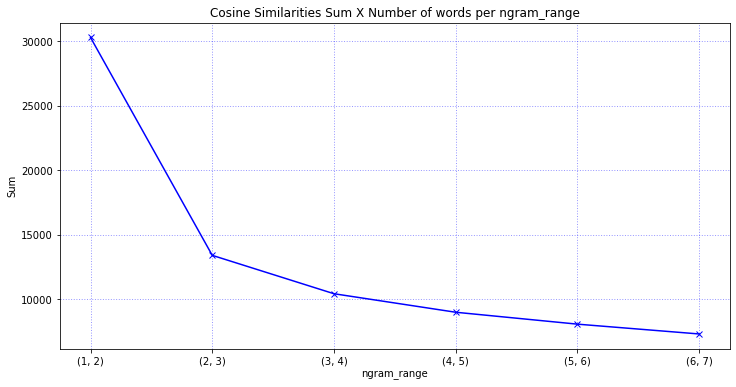

In [73]:
plt.figure(figsize=(12,6))
plt.grid(axis='both', color='b', linestyle=':', linewidth=1, which='major', alpha=0.4, animated=True)
plt.plot([str(i) for i in ngram_list], _sum_cossim_list, 'bx-')
#plt.plot([str(i) for i in ngram_list], _sum_eucdist_list, 'gx-')
plt.xlabel('ngram_range')
plt.ylabel('Sum')
plt.title(r'Cosine Similarities Sum X Number of words per ngram_range')
plt.show()

In [74]:
#vectorization

vect = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       max_df=0.8,
                       min_df=1,
                       tokenizer=None,
                       analyzer='word',
                       ngram_range=(2,3),
                       vocabulary=None)

In [76]:
doc_tfidf = vect.fit_transform(data_orig['tokenStemText'])

In [78]:
doc_tfidf.shape

(1118, 375139)

In [80]:
#doc_tfidf.todense()[0].tolist()

In [82]:
tfidf_cossim = pd.DataFrame(data=cosine_similarity(doc_tfidf),
                            index=data_orig['infracaoId'].tolist(),
                            columns=data_orig['infracaoId'].tolist())

In [105]:
topNSimilarViolations(tfidf_cossim, 5, 222618)

222469    0.715868
209607    0.513010
209576    0.504013
222086    0.478050
206647    0.466400
Name: 222618, dtype: float64

#### Doc2Vec (pre-trained, NILC-USP)

In [170]:
corpus = [document.split() for document in data_orig['tokenizedText']]

In [172]:
model = KeyedVectors.load_word2vec_format('../Code/nilc_word2vec/cbow_s300.txt', binary=False)

In [173]:
termsim_index = WordEmbeddingSimilarityIndex(model)

In [174]:
# Build the term dictionary
dictionary = Dictionary(corpus)

# Build the IDF mapping (corpus is ignored).
tfidf = TfidfModel(dictionary=dictionary) 

In [175]:
bow_corpus = [dictionary.doc2bow(document) for document in corpus]

In [259]:
# Build a sparse term similarity matrix using a term similarity index.
# dictionary – A dictionary that specifies a mapping between terms and the indices of rows and columns of the resulting term similarity matrix.
# tfidf - A model that specifies the relative importance of the terms in the dictionary. The columns of the term similarity matrix will be build in a decreasing order of importance of terms.

similarity_matrix = SparseTermSimilarityMatrix(termsim_index,
                                               dictionary=dictionary,
                                               tfidf=tfidf)

In [260]:
# Compute soft cosine similarity against a corpus of documents by storing the index matrix in memory.
# corpus – A list of documents in the BoW format.
# similarity_matrix – A term similarity matrix.

doc2vec_cossim_index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in corpus]],
                                            similarity_matrix)

In [261]:
doc2vec_cossim = pd.DataFrame(columns=data_orig['infracaoId'].tolist())

for document in tqdm(data_orig['tokenizedText']):
    query_tf = tfidf[dictionary.doc2bow(document.split())]
    doc_similarity_scores = doc2vec_cossim_index[query_tf]
    try:
        doc2vec_cossim = doc2vec_cossim.append(dict(zip(doc2vec_cossim.columns, doc_similarity_scores)), ignore_index=True)
    except:
        doc2vec_cossim = doc2vec_cossim.append(pd.Series(0, index=doc2vec_cossim.columns), ignore_index=True)

  0%|                                                                                         | 0/1118 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [50:52<00:00,  2.73s/it]


In [262]:
doc2vec_cossim

,232872,232648,206780,206781,222618,232643,207727,207730,207729,207731,...,205273,205272,205265,205274,205275,206651,207376,205881,218515,218516
0,1.000000,0.112788,0.013290,0.013290,0.111752,0.100323,0.088673,0.123152,0.123152,0.123152,...,0.843967,0.843967,0.843967,0.843967,0.843967,0.139762,0.060443,0.092769,0.077722,0.077722
1,0.110389,1.000000,0.028061,0.028061,0.527837,0.137286,0.105412,0.081184,0.081184,0.081184,...,0.121966,0.121966,0.121966,0.121966,0.121966,0.123255,0.029318,0.055106,0.094396,0.094396
2,0.020065,0.051735,1.000000,1.000000,0.046009,0.070933,0.052560,0.095317,0.095317,0.095317,...,0.021423,0.021423,0.021423,0.021423,0.021423,0.025393,0.004850,0.029352,0.047674,0.047674
3,0.020065,0.051735,1.000000,1.000000,0.046009,0.070933,0.052560,0.095317,0.095317,0.095317,...,0.021423,0.021423,0.021423,0.021423,0.021423,0.025393,0.004850,0.029352,0.047674,0.047674
4,0.115499,0.492162,0.033306,0.033306,1.000000,0.128213,0.080008,0.085629,0.085629,0.085629,...,0.113410,0.113410,0.113410,0.113410,0.113410,0.116313,0.030285,0.078018,0.089477,0.089477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.130293,0.112236,0.028608,0.028608,0.128643,0.103585,0.057054,0.110575,0.110575,0.110575,...,0.128969,0.128969,0.128969,0.128969,0.128969,1.000000,0.040371,0.084511,0.070035,0.070035
1114,0.170985,0.048810,0.049454,0.049454,0.053208,0.111511,0.085049,0.073069,0.073069,0.073069,...,0.154266,0.154266,0.154266,0.154266,0.154266,0.126148,1.000000,0.126891,0.068330,0.068330
1115,0.125804,0.089287,0.019848,0.019848,0.129685,0.090237,0.096691,0.082035,0.082035,0.082035,...,0.119311,0.119311,0.119311,0.119311,0.119311,0.214890,0.071943,1.000000,0.098009,0.098009
1116,0.090175,0.100340,0.015339,0.015339,0.112666,0.130368,0.078546,0.156390,0.156390,0.156390,...,0.098765,0.098765,0.098765,0.098765,0.098765,0.140771,0.027475,0.092447,1.000000,1.000000


In [265]:
data_orig[data_orig['infracaoId']==232872].docContSplitted[0]

' 31/03/2020 falta: insuficiência de cobertura das reservas técnicas. qualificação do agente supostamente responsável: aruana seguradora s. a., cnpj 07.017.295/0001-58. descrição circunstanciada do fato ou do ato constitutivo da suposta infração: a supervisionada não apresentou ativos garantidores vinculados, adequados à legislação em vigor, suficientes para a cobertura de suas provisões técnicas. análise de autoria e materialidade da suposta infração: a supervisionada apresentou r$ 2.671.635,46 de necessidade de cobertura de provisões técnicas referentes ao mês de março/2020. para a cobertura desse saldo, os ativos garantidores vinculados pela sociedade, no dia 31/03/2020, em conformidade com os arts. 101 a 103 da circular susep nº 517/15, apresentaram montante de r$ 2.610.694,88. dessa forma, fica caracterizada uma insuficiência de r$ 60.940,589. dispositivo legal ou infralegal supostamente infringido: art. 1º do regulamento anexo à resolução cmn nº 4.444/2015 c/c arts. 28, 84 e 88 d

In [41]:
gensim_copy = gensim.copy()

In [133]:
doc2vec_cossim['index_'] = data_orig['infracaoId'].tolist()

In [139]:
data_orig

,infracaoId,processoId,docContSplitted,regexCleanedText,posTaggedText,tokenizedText
0,232872,279296,31/03/2020 falta: insuficiência de cobertura ...,31/03/2020 falta: insuficiência de cobertura ...,31/03/2020 falta insuficiência de cobertura da...,31/03/2020 falt insufici cobert reserv técn qu...
1,232648,279256,08/06/2020; 2 - falta: 01 - não enviar à suse...,08/06/2020; 2 - falta: 01 - não enviar à suse...,08/06/2020 2 falta 01 não enviar à susep prazo...,08/06/2020 falt envi susep praz previst legisl...
2,206780,267704,"substabelecimento substabeleço, com reserva de...","substabelecimento substabeleço, com reserva de...",substabelecimento substabeleço com reserva de ...,substabelec substabeleç reserv igual pod pesso...
3,206781,267704,"substabelecimento substabeleço, com reserva de...","substabelecimento substabeleço, com reserva de...",substabelecimento substabeleço com reserva de ...,substabelec substabeleç reserv igual pod pesso...
4,222618,269237,18/05/2020; 2 - falta: 01 - não enviar à suse...,18/05/2020; 2 - falta: 01 - não enviar à suse...,18/05/2020 2 falta 01 não enviar à susep prazo...,18/05/2020 falt envi susep praz previst legisl...
...,...,...,...,...,...,...
1113,206651,266606,dia 25 de outubro de 2015. falta: comercializ...,dia 25 de outubro de 2015. falta: comercializ...,dia de outubro de 2015. falta comercializar pl...,dia outubr 2015. falt comercial plan previdenc...
1114,207376,266589,assunto: seguro (inclusive vgbl)/automóvel/ne...,assunto: seguro (inclusive vgbl)/automóvel/ne...,assunto seguro inclusive vgbl /automóvel/negat...,assunt segur inclusiv vgbl /automóvel/neg auto...
1115,205881,266582,"05/07/2016 falta: não manter, disponibilizar,...","05/07/2016 falta: não manter, disponibilizar,...",05/07/2016 falta não manter disponibilizar exi...,05/07/2016 falt mant disponibil exib prest for...
1116,218515,266575,"27/03/2013, 270 dias após o início da vigênci...","27/03/2013, 270 dias após o início da vigênci...",270 dias após início da vigência contrato de r...,270 dia após iníci vig contrat ressegur 30/06/...


In [134]:
doc2vec_cossim.set_index('index_', inplace=True)

In [135]:
doc2vec_cossim.index.name = None

In [144]:
doc2vec_cossim

,232872,232648,206780,206781,222618,232643,207727,207730,207729,207731,...,205273,205272,205265,205274,205275,206651,207376,205881,218515,218516
232872,1.000000,0.086664,0.041393,0.041393,0.076712,0.132749,0.086793,0.152031,0.152031,0.152031,...,0.860804,0.860804,0.860804,0.860804,0.860804,0.153705,0.033414,0.075465,0.079194,0.079194
232648,0.146294,1.000000,0.046248,0.046248,0.460571,0.140827,0.095690,0.118902,0.118902,0.118902,...,0.122353,0.122353,0.122353,0.122353,0.122353,0.149745,0.079301,0.055789,0.099858,0.099858
206780,0.070473,0.024204,1.000000,1.000000,0.029798,0.052596,0.010370,0.070224,0.070224,0.070224,...,0.038935,0.038935,0.038935,0.038935,0.038935,0.012034,0.010382,0.049060,0.068850,0.068850
206781,0.070473,0.024204,1.000000,1.000000,0.029798,0.052596,0.010370,0.070224,0.070224,0.070224,...,0.038935,0.038935,0.038935,0.038935,0.038935,0.012034,0.010382,0.049060,0.068850,0.068850
222618,0.143536,0.435139,0.086331,0.086331,1.000000,0.149247,0.101380,0.119246,0.119246,0.119246,...,0.123785,0.123785,0.123785,0.123785,0.123785,0.141646,0.083572,0.075364,0.085746,0.085746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206651,0.071485,0.079545,0.024949,0.024949,0.081718,0.098022,0.047483,0.142452,0.142452,0.142452,...,0.081005,0.081005,0.081005,0.081005,0.081005,1.000000,0.014457,0.082188,0.050664,0.050664
207376,0.100389,0.153824,0.009619,0.009619,0.158711,0.061232,0.177773,0.048848,0.048848,0.048848,...,0.100705,0.100705,0.100705,0.100705,0.100705,0.079884,1.000000,0.094241,0.047502,0.047502
205881,0.127208,0.102109,0.036540,0.036540,0.159703,0.140323,0.092604,0.070724,0.070724,0.070724,...,0.109520,0.109520,0.109520,0.109520,0.109520,0.275968,0.065691,1.000000,0.094527,0.094527
218515,0.163687,0.142840,0.059904,0.059904,0.139602,0.208030,0.124606,0.149912,0.149912,0.149912,...,0.135740,0.135740,0.135740,0.135740,0.135740,0.125906,0.027201,0.112487,1.000000,1.000000


In [67]:
with pd.ExcelWriter('similarities.xlsx') as writer:  
    cossim.to_excel(writer, sheet_name='CosSim')
    gensim.to_excel(writer, sheet_name='GenSim')

In [59]:
topNSimilarViolations(gensim, 5, 207730)

206889    0.479378
207674    0.315626
206859    0.307426
207823    0.297213
222040    0.291506
Name: 207730, dtype: float64

In [242]:
topNSimilarViolations(cossim, 5, 207730)

206889    0.203899
209689    0.169371
209267    0.143115
209262    0.143115
209265    0.143115
Name: 207730, dtype: float64

In [246]:
topNSimilarViolations(gensim, 5, 232872)

207949    0.961208
207945    0.956699
205390    0.947224
222485    0.939442
205848    0.929410
Name: 232872, dtype: float64

In [247]:
topNSimilarViolations(cossim, 5, 232872)

205390    0.904341
222633    0.904187
207949    0.898507
207945    0.898465
222477    0.886033
Name: 232872, dtype: float64

In [248]:
topNSimilarViolations(gensim, 5, 222618)

209607    0.840806
222086    0.774409
209576    0.682943
222469    0.674971
207424    0.673668
Name: 222618, dtype: float64

In [249]:
topNSimilarViolations(cossim, 5, 222618)

222469    0.845703
222250    0.663908
232648    0.631793
209607    0.504023
208310    0.500684
Name: 222618, dtype: float64

In [256]:
# original violation
data_orig.loc[data_orig['infracaoId']==222618,'docContSplitted'].iloc[0]

' 18/05/2020; 2 - falta: 01 - não enviar à susep, no prazo previsto na legislação, documentos referentes a nomeações de administradores, assembleias gerais e a modificações na diretoria, no conselho de administração, no conselho fiscal ou assemelhado; 3 - agente: companhia de seguros do estado são paulo - cosesp, cnpj nº 62.088.042/0001-83, sede na cidade de são paulo - sp; 4 - descrição circunstanciada do fato: protocolou a documentação referente a agoe realizada de 26/03/2020, processo susep nº 15414.606485/2020-15, em 18/05/2020; 5 - narrativa dos fatos: os processos de eleição para o exercício de cargos em órgãos estatutários de sociedades seguradoras, de capitalização, resseguradoras locais e entidades abertas de previdência complementar devem ser instruídos no prazo máximo de trinta dias, a partir da data de sua realização; 6 - norma infringida: artigo 1º da circular susep nº 526, de 2016; 7 - elementos de prova: carimbo do protocolo na susep em 18/05/2020 (documento sei 0716359)

In [257]:
# 1st gensim
data_orig.loc[data_orig['infracaoId']==209607,'docContSplitted'].iloc[0]

' 12/08/2019; 2 - falta: 01 - não enviar à susep, no prazo previsto na legislação, documentos referentes a nomeações de administradores, assembleias gerais e a modificações na diretoria, no conselho de administração, no conselho fiscal ou assemelhado; 3 - agente: axa seguros s.a., cnpj nº 19.323.190/0001-06, com sede na cidade de são paulo - sp; 4 - descrição circunstanciada do fato: protocolou a documentação referente a assembleia geral extraordinária realizada em 01/07/2019 somente em 12/08/2019; 5 - narrativa dos fatos: os processos de eleição para o exercício de cargos em órgãos estatutários de sociedades seguradoras, de capitalização, resseguradoras locais e entidades abertas de previdência complementar devem ser instruídos no prazo máximo de trinta dias, a partir da data de sua realização; 6 - norma infringida: artigo 1º da circular susep nº 526, de 2016; 7 - elementos de prova: carimbo do protocolo na susep em 12/08/2019 (fl.01 do documento 0562722) e ata da age realizada em 01/

In [264]:
# 1st cossim
data_orig.loc[data_orig['infracaoId']==222469,'docContSplitted'].iloc[0]

' 05/05/2020; 2 - falta: 01 - não enviar à susep, no prazo previsto na legislação, documentos referentes a nomeações de administradores, assembleias gerais e a modificações na diretoria, no conselho de administração, no conselho fiscal ou assemelhado; 3 - agente: companhia de seguros do estado são paulo - cosesp, cnpj nº 62.088.042/0001-83, sede na cidade de são paulo - sp; 4 - descrição circunstanciada do fato: protocolou a documentação referente a rca realizada de 19/03/2020, processo susep nº 15414.605960/2020-28, em 05/05/2020; 5 - narrativa dos fatos: os processos de eleição para o exercício de cargos em órgãos estatutários de sociedades seguradoras, de capitalização, resseguradoras locais e entidades abertas de previdência complementar devem ser instruídos no prazo máximo de trinta dias, a partir da data de sua realização; 6 - norma infringida: artigo 1º da circular susep nº 526, de 2016; 7 - elementos de prova: carimbo do protocolo na susep em 05/05/2020 (documento sei 0690801) 

# Clustering violations using existing variables
## (pessoaFisica, faltaId, legislacaoId)

In [86]:
import matplotlib.pyplot as plt
import seaborn as sb

In [88]:
def cor_heatmap(df, method, figsize):
    fig, ax = plt.subplots(figsize=figsize)
    sb.set(font_scale=1.2)
    heat_map = sb.heatmap(df.corr(method = method).round(decimals=2), annot=True, ax=ax, cmap = 'coolwarm')
    plt.show()

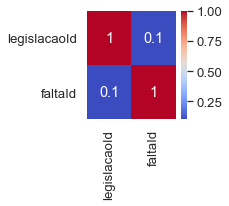

In [89]:
cor_heatmap(data_orig[['legislacaoId', 'faltaId']], 'spearman', (2,2))

In [69]:
cluster_data = data_orig['pessoaFisica']

In [70]:
encoder = OneHotEncoder()

In [71]:
faltaId_ = data_orig['faltaId'].copy()

In [72]:
enc_faltaId = encoder.fit_transform(faltaId_.to_numpy().reshape(-1, 1)).todense()

In [73]:
enc_faltaId = pd.DataFrame(enc_faltaId, columns=encoder.categories_[0].tolist())

In [75]:
cluster_data = enc_faltaId.merge(cluster_data, left_index=True, right_index=True)

In [77]:
legislacaoId_ = data_orig['legislacaoId'].copy()

In [78]:
enc_legislacaoId = encoder.fit_transform(legislacaoId_.to_numpy().reshape(-1, 1)).todense()

In [79]:
enc_legislacaoId = pd.DataFrame(enc_legislacaoId, columns=encoder.categories_[0].tolist())

In [80]:
cluster_data = cluster_data.merge(enc_legislacaoId, left_index=True, right_index=True)

In [81]:
cluster_data.shape

(1118, 147)

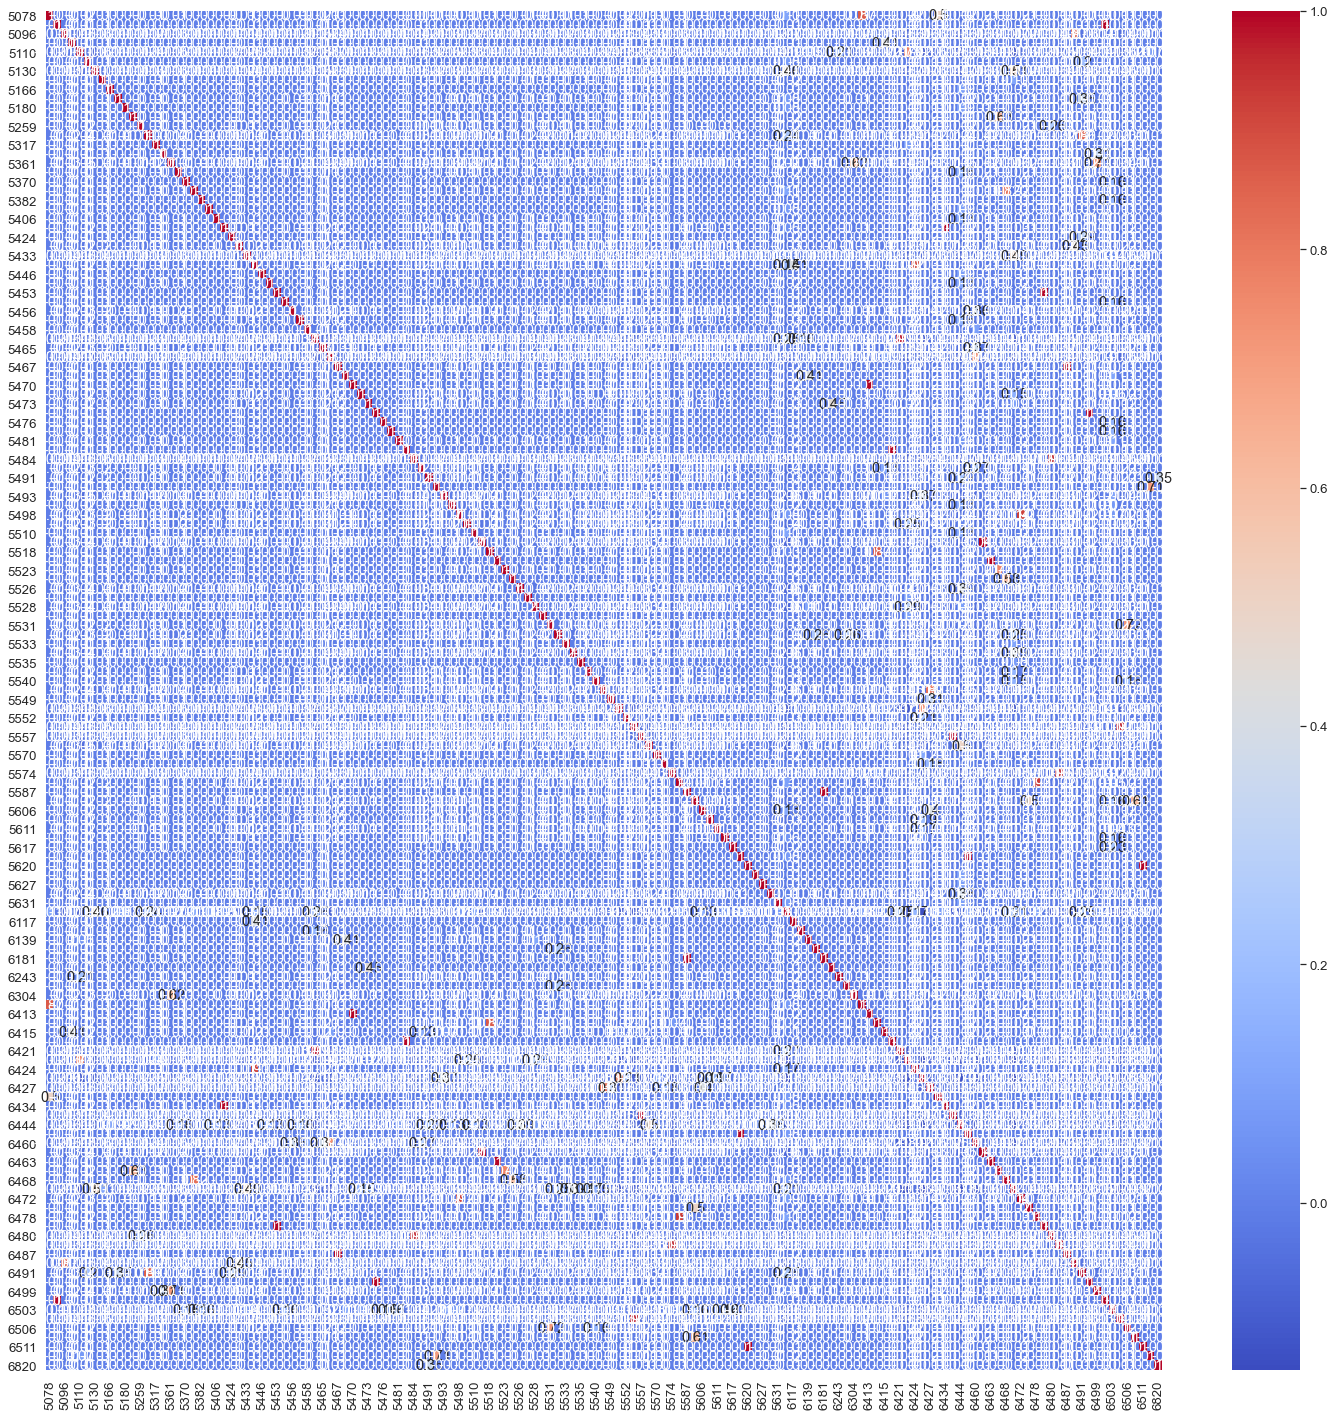

In [91]:
cor_heatmap(cluster_data, 'spearman', (25,25))

In [92]:
# Create correlation matrix
corr_matrix = cluster_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
cluster_data.drop(to_drop, axis=1, inplace=True)

In [94]:
len(to_drop)

26

In [97]:
cluster_data = cluster_data.merge(data_orig['infracaoId'], left_index=True, right_index=True)

In [99]:
cluster_data.set_index('infracaoId', inplace=True)

In [101]:
cluster_data.index.name = None

In [96]:
from sklearn.cluster import KMeans

In [162]:
num_clusters = 35

km = KMeans(n_clusters=num_clusters)

%time km.fit(cluster_data)

clusters = km.labels_.tolist()

Wall time: 384 ms


<AxesSubplot:>

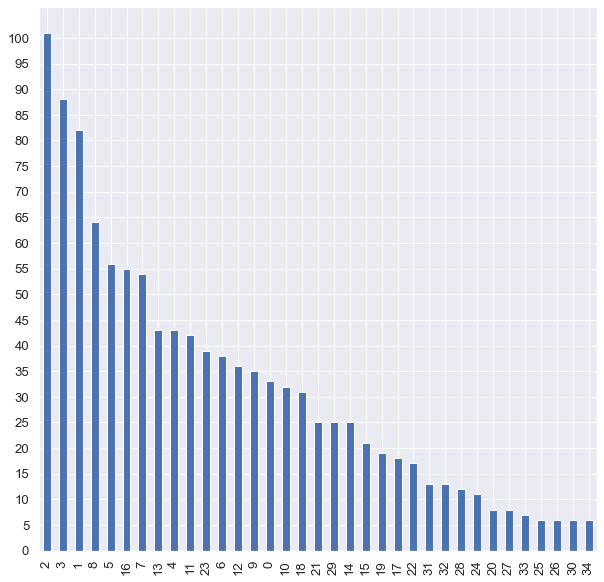

In [166]:
pd.value_counts(km.labels_).plot(kind='bar', figsize=(10,10), grid=True, yticks=range(0,105,5))

In [121]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_data)
    Sum_of_squared_distances.append(km.inertia_)

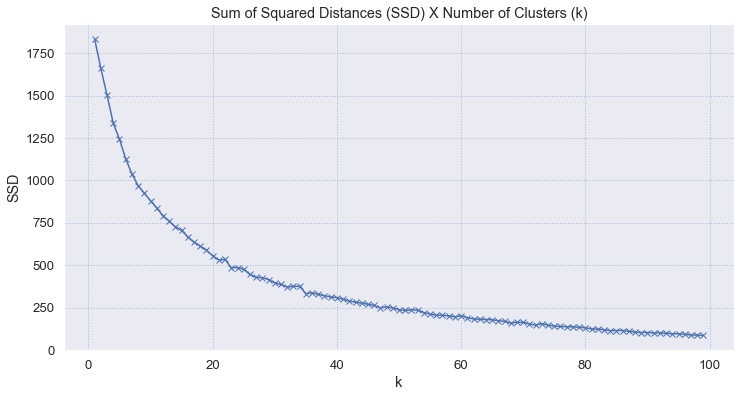

In [158]:
plt.figure(figsize=(12,6))
plt.grid(axis='both', color='b', linestyle=':', linewidth=1, which='major', alpha=0.4, animated=True)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSD')
plt.title(r'Sum of Squared Distances (SSD) X Number of Clusters (k)')
plt.show()

In [168]:
from scipy.spatial import distance

In [186]:
# Testing hamming distance for categorical data\

dist_array = distance.cdist(cluster_data, cluster_data, 'hamming')

In [187]:
pd.DataFrame(dist_array)

,0,1,2,3,4,5,6,7,8,9,...,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117
0,0.000000,0.016529,0.016529,0.016529,0.016529,0.024793,0.016529,0.024793,0.024793,0.024793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.024793,0.024793,0.024793,0.033058,0.024793
1,0.016529,0.000000,0.016529,0.016529,0.000000,0.024793,0.016529,0.024793,0.024793,0.024793,...,0.016529,0.016529,0.016529,0.016529,0.016529,0.024793,0.024793,0.024793,0.033058,0.024793
2,0.016529,0.016529,0.000000,0.000000,0.016529,0.024793,0.016529,0.024793,0.024793,0.024793,...,0.016529,0.016529,0.016529,0.016529,0.016529,0.024793,0.024793,0.024793,0.033058,0.024793
3,0.016529,0.016529,0.000000,0.000000,0.016529,0.024793,0.016529,0.024793,0.024793,0.024793,...,0.016529,0.016529,0.016529,0.016529,0.016529,0.024793,0.024793,0.024793,0.033058,0.024793
4,0.016529,0.000000,0.016529,0.016529,0.000000,0.024793,0.016529,0.024793,0.024793,0.024793,...,0.016529,0.016529,0.016529,0.016529,0.016529,0.024793,0.024793,0.024793,0.033058,0.024793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.024793,0.024793,0.024793,0.024793,0.024793,0.016529,0.024793,0.033058,0.033058,0.033058,...,0.024793,0.024793,0.024793,0.024793,0.024793,0.000000,0.033058,0.033058,0.024793,0.033058
1114,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.033058,0.033058,...,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.000000,0.033058,0.041322,0.033058
1115,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.033058,0.033058,...,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.033058,0.000000,0.041322,0.033058
1116,0.033058,0.033058,0.033058,0.033058,0.033058,0.024793,0.033058,0.041322,0.041322,0.041322,...,0.033058,0.033058,0.033058,0.033058,0.033058,0.024793,0.041322,0.041322,0.000000,0.024793


In [171]:
num_clusters = (len(data_orig['tokenizedText']) // 10) + 1

km = KMeans(n_clusters=num_clusters)

%time km.fit(doc_vectors)

clusters = km.labels_.tolist()

Wall time: 6min 6s


In [266]:
from collections import Counter

In [267]:
Counter(clusters)

Counter({7: 54,
         14: 25,
         1: 82,
         21: 25,
         11: 42,
         5: 56,
         8: 64,
         28: 12,
         29: 25,
         16: 55,
         34: 6,
         23: 39,
         9: 35,
         10: 32,
         2: 101,
         0: 33,
         3: 88,
         12: 36,
         18: 31,
         15: 21,
         26: 6,
         27: 8,
         4: 43,
         6: 38,
         22: 17,
         20: 8,
         25: 6,
         17: 18,
         31: 13,
         33: 7,
         19: 19,
         13: 43,
         30: 6,
         32: 13,
         24: 11})